In [1]:
from random import gauss



Load the Global Land Temperature dataset as a list of lists. Before starting, take a moment to bet-
ter inspect the attributes you are going to work on. How many of them are nominal, how many
continuous or discrete?

As you can see, many of the columns are nominal, while there are two numerical continuous attributes: AverageTemperature and AverageTemperatureUncertainty.

In [2]:
import csv
dataset = [[],[],[],[],[],[],[]]
labels = []

with open("GLT_filtered.csv") as file:
    csv_reader = csv.reader(file)
    labels = next(csv_reader)
    
    for row in csv_reader:
        if len(row) == len(labels): # every column must be present
            for i in range(len(dataset)):
                dataset[i].append(row[i])
    


Exercise 1.2

The columns AverageTemperature and AverageTemperatureUncertainty contain missing values. By simply counting them, we obtain:


In [3]:
def count_missing(data):
    return sum([1 for d in data if d == '' or d == ' ' or d == 'Null' or d == 'NaN' or d == None])

row_count = len(dataset[0])
print(f'AverageTemperature, missing values out of the whole data: {100*count_missing(dataset[1])/row_count:.2f}%')
print(f'AverageTemperatureUncertainty, missing values out of the whole data: {100*count_missing(dataset[2])/row_count:.2f}%')

AverageTemperature, missing values out of the whole data: 12.56%
AverageTemperatureUncertainty, missing values out of the whole data: 12.56%


Analyze the attribute AverageTemperature, which contains missing values. Fill any gap with the
arithmetic mean among the closest antecedent and the closest successive measurements in time,
taken in the same city. Assume the following rules for edge cases:

In [4]:
def fill_gaps(data, cities):
    right_i = 0
    right_v = 0

    for i, value in enumerate(data):
        if i == 0 or cities[i] != cities[i-1]:
            left_v = 0
        else: 
            left_v = data[i-1]
# reuse the right_v value, useful when there are multiple consecutive missing values
        if i<right_i:
            data[i] = (left_v + right_v)/2
            continue


        if value == '':
            for j in range(i+1, len(data)):
                if cities[j] != cities[i]: # this check must come before
                    right_v = 0
                    break
                elif data[j] != '':
                    right_v = float(data[j])
                    break
            if i==len(data)-1: # edge case: the last value of the last city is empty
                right_v = 0
            right_i = j
            data[i] = (left_v + right_v) / 2
        else:
            data[i] = float(data[i])

    
        


Version B

The main idea is to work on measurements for each city separately. The data structure that helps here is the dictionary (this is true whenever you need to store and access quickly to something by any key value).

So, let's extract the distinct cities and count them.


In [5]:
cities = set(dataset[3])

avg_temp = {}
avg_temp_unc = {}

for city in cities:
    indices = [i for i,c in enumerate(dataset[3]) if c==city]
    avg_temp[city] = [dataset[1][i] for i in indices]
    avg_temp_unc[city] = [dataset[2][i] for i in indices]

In [6]:
def fill_gaps(data):
    right_i = 0
    right_v = 0

    for i, value in enumerate(data):
        left_v = data[i-1] if i != 0 else 0

        # reuse the right_v value, useful when there are multiple consecutive missing values
        if i < right_i:
            data[i] = (left_v + right_v)/2
            continue

        if value == '':
            try:
                # use a generator to search for the first occurrence
                right_i, right_v = next((idx+i+1, float(v)) for idx,v in enumerate(data[i+1:]) if v!= '')
            except StopIteration: # fired when the generator has no items left to iterate on
                right_i = len(data)
                right_v = 0
            data[i] = (left_v + right_v) / 2
        else:
            data[i] = float(data[i]) # parse to float all present values


In [7]:
for city in cities:
    fill_gaps(avg_temp[city])
    fill_gaps(avg_temp_unc[city])

Define a function that, given the name of a city and an integer N > 0, prints:
(a) the top N hottest measurements;
(b) the top N coldest measurements.

Here we can use the dictionaries from Version B.

In [8]:

def top_n_measurements(avg_temp, city, N):
    sorted_measurements = sorted(avg_temp[city], reverse = True)
    print(f'The top {N} hottest measurements taken in {city} are: ', sorted_measurements[:N])
    print(f'The top {N} coolest measurements taken in {city} are: ', sorted_measurements[-1: -(N+1): -1])



In [9]:
top_n_measurements(avg_temp, 'Rome', 5)

The top 5 hottest measurements taken in Rome are:  [25.951, 24.998, 24.873, 24.730999999999998, 24.48]
The top 5 coolest measurements taken in Rome are:  [-1.4410000000000005, -1.3039999999999994, -1.0189999999999997, -0.871, -0.7829999999999999]


Let’s search for other anomalies in data distribution with the help of matplotlib. Plot the distri-
bution of the average land temperatures for Rome and Bangkok using the aforementioned histogram
plotting function.

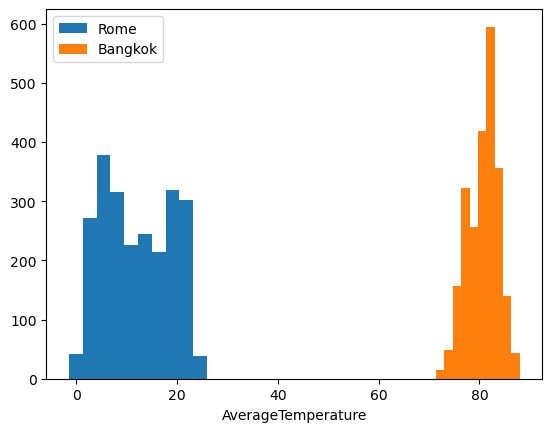

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

for city in ['Rome', 'Bangkok']:
    plt.hist(avg_temp[city], label=city)
plt.legend()
_ = plt.xlabel('AverageTemperature')
plt.show()


In [11]:
import numpy as np

print(f'Rome average temperature: {np.mean(avg_temp["Rome"]):.2f}, Standard deviation: {np.std(avg_temp["Rome"]):.2f}')
print(f'Bangkok average temperature: {np.mean(avg_temp["Bangkok"]):.2f}, Standard deviation: {np.std(avg_temp["Bangkok"]):.2f}')



Rome average temperature: 12.01, Standard deviation: 6.69
Bangkok average temperature: 80.73, Standard deviation: 3.04


Perhaps the enormous difference is because bangkok's temperature measurements were done in fahrenheit.

In [12]:
def fah2cel(fah):
    return (fah-32) / 1.8

In [13]:
bangkok_celsius = [fah2cel(m) for m in avg_temp['Bangkok']]


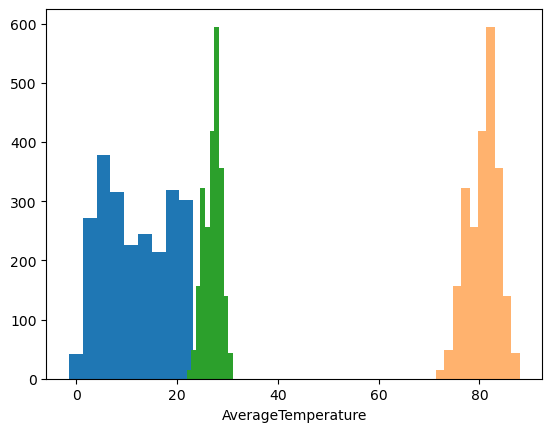

In [14]:

plt.rcParams['figure.dpi'] = 100
plt.hist(avg_temp['Rome'], label = 'Rome')
plt.hist(avg_temp['Bangkok'], label = 'Bangkok Fahrenheit', alpha = 0.6)
plt.hist(bangkok_celsius, label= 'Bangkok Celsius')
_ = plt.xlabel('AverageTemperature')
plt.show()

In [15]:
print(f'Rome average temperature: {np.mean(avg_temp["Rome"]):.2f}, Standard deviation: {np.std(avg_temp["Rome"]):.2f}')
print(f'Bangkok average temperature: {np.mean(bangkok_celsius):.2f}, Standard deviation: {np.std(bangkok_celsius):.2f}')

Rome average temperature: 12.01, Standard deviation: 6.69
Bangkok average temperature: 27.07, Standard deviation: 1.69
